# <center>  **Training Convolutional Neural Networks Using Genetic Algorithms and Enhancing Performance with Ensemble Learning** </center>

---

## **Abstract**
This tutorial explores how to train Convolutional Neural Networks (CNNs) using GA, evaluating different CNN architectures to assess their effectiveness. After comparing GA-trained models in terms of accuracy, convergence speed, and computational cost, we further enhance performance by applying ensemble learning techniques. The goal is to demonstrate how model ensembling can improve classification accuracy by leveraging multiple GA-optimized networks for better decision-making.

## **Learning objective**
By the end of this tutorial, you will:

- **Understand Genetic Algorithms (GA)** and how they can be used to optimize Convolutional Neural Networks (CNNs).  
- **Implement GA for CNN training in PyTorch**, including selection, crossover, and mutation techniques.  
- **Compare different CNN models trained using GA**, analyzing accuracy, convergence, and computational efficiency.  
- **Apply Ensemble Learning techniques** to improve classification performance by combining GA-trained CNNs.  
- **Visualize model performance** using accuracy/loss curves and per-class accuracy analysis.  
- **Gain practical experience** in evolutionary optimization and ensemble learning, enhancing deep learning pipelines.  

## **Table of Contents**
1. [Introduction](#Introduction)
2. [CNN Architectures Used](#CNN-Architectures-Used)
3. [Implementing Genetic Algorithm for CNN Training](#Implementing-Genetic-Algorithm-for-CNN-Training)
4. [Comparing CNNs Trained Using Genetic Algorithms and Traditional Methods](#Comparing-CNNs-Trained-Using-Genetic-Algorithms-and-Traditional-Methods)
5. [Ensemble Learning: Combining GA-Trained CNNs](#Ensemble-Learning-Combining-GA-Trained-CNNs)
6. [Evaluation and Visualization](#Evaluation-and-Visualization)
7. [Conclusion](#Conclusion)
8. [Tutorial comparison](#Tutorial-comaprison)
9. [References](#References)
<br>

---


## **Introduction**
Training **Convolutional Neural Networks (CNNs)** efficiently is a key challenge in deep learning. Traditional optimization techniques such as **Stochastic Gradient Descent (SGD)** and **Adam** rely on backpropagation to update model weights. However, **Genetic Algorithms (GAs)** provide an alternative approach by evolving network parameters through a population-based optimization process.

This tutorial explores how **Genetic Algorithms (GA) can be used to train CNNs** without relying on gradient-based methods. By implementing **selection, crossover, and mutation**, we optimize CNN weights across multiple generations. The **performance of GA-trained CNNs** is then evaluated and compared, highlighting accuracy trends and computational costs.

Finally, we **apply ensemble learning techniques** to combine multiple GA-trained models into a single classifier, aiming to improve classification performance. This hybrid approach leverages the strengths of different models, leading to a more robust deep learning solution.

### **What is a CNN?** <br>
A **Convolutional Neural Network (CNN)** is a type of deep learning model specifically designed for **image classification and processing**. Unlike traditional neural networks, CNNs use specialized layers to extract spatial and hierarchical features from images.

CNNs are widely used in **computer vision tasks**, such as **object detection, facial recognition, and medical imaging**, due to their ability to automatically learn important features from raw pixel data.

---

### **How Do CNNs Work?** <br>
CNNs operate by applying a series of transformations to an input image, gradually extracting meaningful patterns:

| **Stage** | **Description** |
|-----------|---------------|
| **1. Convolution** | Applies **filters (kernels)** to detect patterns like edges and textures. |
| **2. Activation Function (ReLU)** | Introduces **non-linearity** to allow the model to learn complex features. |
| **3. Pooling (Max/Average)** | Downsamples the feature maps, reducing computation and improving generalization. |
| **4. Flattening** | Converts multi-dimensional feature maps into a 1D vector for classification. |
| **5. Fully Connected (FC) Layers** | Processes extracted features and makes predictions. |

Each layer contributes to making CNNs **highly efficient for image recognition tasks**.

### **What is a Genetic Algorithm?**
A **Genetic Algorithm (GA)** is an evolutionary optimization technique inspired by **natural selection**. It evolves a population of solutions over generations to optimize a given objective function. Instead of using gradients to adjust weights (as in traditional deep learning), GA applies:
- **Selection**: Choosing the best-performing models (high accuracy CNNs).
- **Crossover**: Mixing features from selected models to create new ones.
- **Mutation**: Slightly altering model parameters to introduce diversity.


---
### **Libraries**


In [38]:
# PyTorch libraries for neural network operations and optimization algorithms.
import torch                                    # torch: PyTorch library for tensor operations and neural network functionalities.
import torch.nn as nn                           # torch.nn: PyTorch library for neural network layers and operations.
import torch.nn.functional as F                 # torch.nn.functional: PyTorch library for activation functions and other neural network operations.
import torch.optim as optim                     # torch.optim: PyTorch library for optimization algorithms like SGD and Adam.
import torchvision                              # torchvision: PyTorch library for computer vision tasks.
import torchvision.transforms as transforms     # torchvision.transforms: PyTorch library for data augmentation and preprocessing of images.

import matplotlib.pyplot as plt                 # matplotlib.pyplot: For plotting graphs and visualizing images.
import numpy as np                              # numpy: For numerical operations and array manipulations.

import time                                     # time: For measuring training and evaluation time.
import random                                   # random: For random operations like shuffling and selecting random samples.

import seaborn as sns
from sklearn.metrics import confusion_matrix

import pandas as pd

In [2]:
# print the system information
print("Torch version : ", torch.__version__)                                  # PyTorch version
print("Cuda availability : ", torch.cuda.is_available(), "\n")                # GPU availability

if torch.cuda.is_available():
	print("Device name : ",torch.cuda.get_device_name(0))        # GPU device name
	print("Device ID : ",torch.cuda.current_device())          # GPU device ID
else:
	print("CUDA is not available. Running on CPU.")

Torch version :  2.5.1+cu124
Cuda availability :  True 

Device name :  NVIDIA A100-SXM4-40GB
Device ID :  0


---
### **Dataset Used: CIFAR-10**

The **CIFAR-10** dataset is used for training and evaluating the CNN models in this tutorial. It is a well-known benchmark dataset in computer vision, widely used for image classification tasks.

#### **Dataset Overview**
- **Total Images**: 60,000
- **Image Size**: 32x32 pixels
- **Number of Classes**: 10
- **Training Set**: 50,000 images
- **Test Set**: 10,000 images
- **Color Channels**: RGB (3 channels)

#### **CIFAR-10 Classes**
The dataset contains **10 categories**, each with **6,000 images**:
1. **Plane**  
2. **Car**  
3. **Bird**
4. **Cat**  
5. **Deer**  
6. **Dog**
7. **Frog**
8. **Horse**
9. **Ship**
10. **Truck**

In [3]:
#CIFAR10 dataset

# Load and normalise CIFAR10 dataset from Source [1]
# Define a transform to normalize the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Set the batch size for loading data
batch_size = 4

# Download and load the training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Download and load the test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Define the classes in the dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### End of source [1]

# source [1] : https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

100%|██████████| 170M/170M [00:03<00:00, 43.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


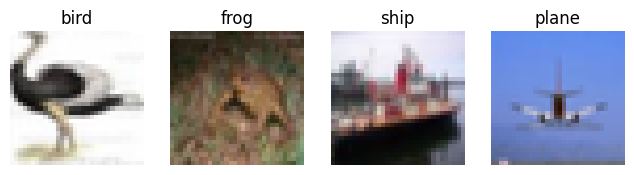

In [4]:
#function that shows images with their labels
def show_images_labels(images, labels):
    plt.figure(figsize=(10, 4))
    for i in range(4):
        plt.subplot(2, 5, i + 1)
        img = images[i] / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.title(f"{classes[labels[i]]}")
        plt.axis('off')
    plt.show()

# get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)

show_images_labels(images, labels)

---

## **CNN Architectures Used** <a id="CNN-Architectures-Used"></a>

**CNN Architectures Used in This Project** <br>

This project implements and compares three different **Convolutional Neural Network (CNN)** architectures for **CIFAR-10 image classification**:

1. **Custom CNN Model (CNN)**
2. **Modified CNN Model (CNN_2)**
3. **LeNet-5 (Modified for CIFAR-10)**

These models are designed to process **RGB images of size 32x32x3** and classify them into one of **10 CIFAR-10 classes**.

---


**Custom CNN Model (CNN)** <br>
The **Custom CNN Model** is a simple yet effective architecture for CIFAR-10 classification. It consists of:
- **Two convolutional layers** for feature extraction.
- **Two max pooling layers** for reducing spatial dimensions.
- **Two fully connected layers** for classification.

**Model Architecture**

| **Layer Type**  | **Details** |
|-----------------|------------|
| **Conv2D (1st Layer)** | 32 filters, kernel size **3x3**, stride **1**, padding **1** |
| **Activation**  | ReLU |
| **Max Pooling** | Kernel size **2x2**, stride **2** |
| **Conv2D (2nd Layer)** | 64 filters, kernel size **3x3**, stride **1**, padding **1**|
| **Activation**  | ReLU |
| **Max Pooling** | Kernel size **2x2**, stride **2** |
| **Flatten**     | Converts feature maps into a 1D vector |
| **Fully Connected (FC1)** | 128 neurons, ReLU |
| **Fully Connected (FC2)** | 10 neurons, Log Softmax for classification |

**Modifications for CIFAR-10:**
- Adjusted input channels to **3** (RGB images).
- Adjusted the input size for the fully connected layer.
- Output layer has **10 neurons** for CIFAR-10 classes.
- Uses **ReLU activation** instead of traditional **tanh** to improve convergence.

In [23]:
# Define the CNN model from Source [2] modified so it can be used for CIFAR10 dataset
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # Changed input channels to 3 for RGB images
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Adjusted input size for fully connected layer
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 64 * 8 * 8)  # Adjusted view size to match the output of conv layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)
### End of source [2]


---

**Modified CNN Model (CNN_2)** <br>
This architecture improves on the basic CNN by incorporating **dropout regularization** and a different convolutional structure. It consists of:
- **Two convolutional layers** with increased filter depth.
- **Two pooling layers** to downsample feature maps.
- **Dropout layer** to prevent overfitting.
- **Fully connected output layer** using log softmax for classification.

**Model Architecture**

| **Layer Type**  | **Details** |
|-----------------|------------|
| **Conv2D (1st Layer)** | 12 filters, kernel size **5x5** |
| **Activation**  | ReLU |
| **Max Pooling** | Kernel size **2x2**, stride **2** |
| **Conv2D (2nd Layer)** | 24 filters, kernel size **5x5** |
| **Activation**  | ReLU |
| **Max Pooling** | Kernel size **2x2**, stride **2** |
| **Dropout** | 20% probability to prevent overfitting |
| **Flatten** | Converts feature maps into a 1D vector |
| **Fully Connected (FC - Output Layer)** | 10 neurons, Log Softmax for classification |

**Modifications for CIFAR-10:**
- Increased filter depth (12 and 24 filters for improved feature extraction).
- Added **Dropout layer** for better generalization.
- Uses **Log Softmax** for stable probability distribution in classification.


In [21]:
# modified the defined model from source [4] to be used for the CIFAR10 dataset
class CNN_2(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_2, self).__init__()

        # In the init function, we define each layer we will use in our model

        # Our images are RGB, so we have input channels = 3.
        # We will apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5)

        # A second convolutional layer takes 12 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5)

        # We in the end apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)

        # We need to flatten these in order to feed them to a fully-connected layer
        self.fc = nn.Linear(in_features=5 * 5 * 24, out_features=num_classes)

    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function

        # Use a ReLU activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x)))

        # Use a ReLU activation function after layer 2
        x = F.relu(self.pool(self.conv2(x)))

        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)

        # Flatten
        x = x.view(-1, 5 * 5 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function
        return torch.log_softmax(x, dim=1)
### End of source [4]


---

**LeNet-5 (Modified for CIFAR-10)** <br>
LeNet-5 is a **classic CNN architecture** originally designed for digit classification (**MNIST**). It has been **modified for CIFAR-10** by:
- Supporting **RGB images** instead of grayscale.
- Adjusting the number of channels and parameters to fit CIFAR-10.
- Using **Tanh**.

**Model Architecture**

| **Layer Type**  | **Details** |
|-----------------|------------|
| **Conv2D (1st Layer)** | 6 filters, kernel size **5x5** |
| **Activation**  | Tanh |
| **Max Pooling** | Kernel size **2x2** |
| **Conv2D (2nd Layer)** | 16 filters, kernel size **5x5** |
| **Activation**  | Tanh |
| **Max Pooling** | Kernel size **2x2** |
| **Flatten** | Converts feature maps into a 1D vector |
| **Fully Connected (FC1)** | 120 neurons, Tanh |
| **Fully Connected (FC2)** | 84 neurons, Tanh |
| **Fully Connected (Output Layer)** | 10 neurons (one per class) |

**Modifications for CIFAR-10:**
- Adjusted input channels from **1 (grayscale) to 3 (RGB)**.
- Maintained **Tanh activations** for compatibility with the original design.
- Adjusted fully connected layers to handle CIFAR-10 images properly.
- Outputs a **softmax probability distribution** over 10 classes.


In [24]:
# Define the CNN model from Source [3] modified so it can be used for CIFAR10 dataset
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()

        self.num_classes = num_classes
        in_channels = 3

        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 6*in_channels, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6*in_channels, 16*in_channels, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16*5*5*in_channels, 120*in_channels),
            nn.Tanh(),
            nn.Linear(120*in_channels, 84*in_channels),
            nn.Tanh(),
            nn.Linear(84*in_channels, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return probas
### End of source [3]



---

**Summary of Modifications for CIFAR-10**

| **Model** | **Key Modifications** |
|----------|-------------------|
| **CNN** | Increased input channels to 3, ReLU activation, CIFAR-10 output size |
| **CNN_2** | Added dropout, increased filter size, Log Softmax for stability |
| **LeNet-5** | RGB support, minor tweaks to convolutional layers and activations |

Each model is **evaluated on CIFAR-10** using different optimization techniques to compare performance and generalization ability.

### **Key training and testing functions.**

#### **Testing**

In [8]:
def test_nn(model, testloader, use_gpu=True):
    """
    Efficiently tests the model on all images in the test set and returns overall accuracy.

    Args:
        testloader: PyTorch DataLoader for test data.
        model: Trained PyTorch model.
        use_gpu (bool, optional): If True, uses GPU if available. Default is True.

    Returns:
        overall_accuracy (float): Accuracy of the model on the test set.
    """
    # Select device (GPU if available, otherwise CPU)
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model.to(device)

    model.eval()  # Set model to evaluation mode

    correct = 0
    total = 0

    # Disable gradient computation for efficiency
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU/CPU
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)  # Get predicted class

            # Update total and correct predictions
            total += labels.size(0)
            correct += (predictions == labels).sum().item()

    # Compute overall accuracy
    overall_accuracy = 100 * correct / total

    # print(f"Overall Model Accuracy: {overall_accuracy:.2f}%")
    return overall_accuracy


In [9]:
def test_nn_per_class(model, testloader, classes, use_gpu=True):
    """
    Efficiently tests the model on all images in the test set and returns per-class accuracy.

    Args:
        testloader: PyTorch DataLoader for test data.
        model: Trained PyTorch model.
        classes: List of class labels.
        use_gpu (bool, optional): If True, uses GPU if available. Default is True.

    Returns:
        class_accuracies (dict): Dictionary containing accuracy for each class.
    """
    # Select device (GPU if available, otherwise CPU)
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    ### code form source [1] modified to be done on the GPU/CPU
    # Prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # Disable gradient computation for efficiency
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU/CPU
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)  # Get predicted class

            # Update per-class statistics
            for label, prediction in zip(labels, predictions):
                total_pred[classes[label.item()]] += 1  # Count total instances of each class
                if label == prediction:
                    correct_pred[classes[label.item()]] += 1  # Count correct predictions

    # Compute per-class accuracy
    class_accuracies = {
        classname: (100 * correct_pred[classname] / total_pred[classname]) if total_pred[classname] > 0 else 0.0
        for classname in classes
    }
    ### end of source [1] class accuracy code

    print("Finished per-class testing.")
    return class_accuracies


#### **Training**

In [10]:
def train_nn(model, trainloader, criterion, optimizer, epochs=2, use_gpu=True, lr_scheduler=False):
    """
    Train a PyTorch CNN model efficiently.

    Args:
        model: PyTorch model to train.
        trainloader: DataLoader containing training data.
        criterion: Loss function.
        optimizer: Optimizer (Adam, SGD, etc.).
        epochs (int, optional): Number of training epochs. Default is 2.
        use_gpu (bool, optional): If True, enables GPU acceleration.
        lr_scheduler (bool, optional): If True, reduces learning rate when loss stops improving.

    Returns:
        train_losses: List of training losses over epochs.
        train_accuracies: List of training accuracies.
        total_training_time: Total training time.
    """

    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to GPU

    # lists to store losses and accuracies
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    total_training_time = 0

    # Learning Rate Scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5) if lr_scheduler else None

    for epoch in range(epochs):
        model.train() # set model to training mode
        epoch_start_time = time.time()

        # collect training statistics
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients begin the forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # backward pass and optimize
            loss.backward()
            optimizer.step()

            # collect statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # calculate the epoch loss and accuracy and save them
        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # get the model acuracy on the test data
        test_accuracy = test_nn(model, testloader, use_gpu)
        test_accuracies.append(test_accuracy)

        # Adjust learning rate if using scheduler
        if lr_scheduler:
            scheduler.step(epoch_loss)

        epoch_training_time = time.time() - epoch_start_time
        total_training_time += epoch_training_time

        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Train_Accuracy: {epoch_accuracy:.2f}% | Test_Accuracy: {test_accuracy:.2f}% | Time: {epoch_training_time:.2f}s")

    return train_losses, train_accuracies, total_training_time, test_accuracies

---

## **Implementing Genetic Algorithm for CNN Training** <a id="Implementing-Genetic-Algorithm-for-CNN-Training"></a>
In this section, we implement a **Genetic Algorithm (GA) to train Convolutional Neural Networks (CNNs)** without using traditional backpropagation. Instead of gradient-based optimization, we evolve CNN parameters over generations using:
- **Selection** (choosing the best models),
- **Crossover** (combining parameters from two parent models),
- **Mutation** (applying small random changes to model parameters).


### **Step 1: Compute Fitness of a Model**
The **fitness function** evaluates a model's performance based on its **test accuracy** after training.


In [11]:
def compute_fitness(criterion, model, optimizer, trainloader, testloader, epochs):
    """
    Computes the fitness of a model by training and evaluating its accuracy.

    Args:
        criterion: Loss function.
        model: PyTorch model to train and evaluate.
        optimizer: Optimizer (Adam, SGD, etc.).
        trainloader: DataLoader containing training data.
        testloader: DataLoader containing test data.
        epochs (int): Number of training epochs.

    Returns:
        fitness (float): Accuracy of the model on the test set.
    """
    # Train the model
    train_nn(model, trainloader, criterion, optimizer, epochs)

    # Test the model
    fitness = test_nn(model, testloader)
    return fitness

### **Step 2: Initialize a Population of CNNs**
A **population** consists of randomly initialized CNN models.


In [12]:
# code from source [2] modified to initialise the population from and model class
# write a function to initialise the population
def initialise_population(population_size, model_class):
    """
    Initializes a population of models.

    Args:
        population_size (int): Number of models in the population.
        model_class (class): The class of the model to be instantiated.

    Returns:
        population (list): List of instantiated models.
    """
    population = []
    for i in range(population_size):
        model = model_class() # modified so it can initialise any model class
        population.append(model)
    return population

### **Step 3: Crossover Operation**
The **crossover function** combines parameters from two parent models to create two child models.

In [13]:
# code from source [2] modified to perform crossover on the any model used.
# write the function to perform the crossover operation
def crossover(parent1, parent2, use_gpu=True):
    """
    Performs crossover operation between two parent models to produce two child models.

    Args:
        parent1: First parent model (CNN or LeNet5).
        parent2: Second parent model (CNN or LeNet5).
        use_gpu (bool, optional): If True, uses GPU if available. Default is True.

    Returns:
        child1: First child model.
        child2: Second child model.
    """
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")

    if isinstance(parent1, CNN) and isinstance(parent2, CNN):
        # Initialize child models
        child1 = CNN().to(device)
        child2 = CNN().to(device)

        # Perform crossover on the convolutional layers
        child1.conv1.weight.data = torch.cat((parent1.conv1.weight.data[:16], parent2.conv1.weight.data[16:]), dim=0).to(device)
        child2.conv1.weight.data = torch.cat((parent2.conv1.weight.data[:16], parent1.conv1.weight.data[16:]), dim=0).to(device)
        child1.conv2.weight.data = torch.cat((parent1.conv2.weight.data[:32], parent2.conv2.weight.data[32:]), dim=0).to(device)
        child2.conv2.weight.data = torch.cat((parent2.conv2.weight.data[:32], parent1.conv2.weight.data[32:]), dim=0).to(device)

        # Perform crossover on the fully connected layers
        child1.fc1.weight.data = torch.cat((parent1.fc1.weight.data[:64], parent2.fc1.weight.data[64:]), dim=0).to(device)
        child2.fc1.weight.data = torch.cat((parent2.fc1.weight.data[:64], parent1.fc1.weight.data[64:]), dim=0).to(device)
        child1.fc2.weight.data = torch.cat((parent1.fc2.weight.data[:5], parent2.fc2.weight.data[5:]), dim=0).to(device)
        child2.fc2.weight.data = torch.cat((parent2.fc2.weight.data[:5], parent1.fc2.weight.data[5:]), dim=0).to(device)

    elif isinstance(parent1, LeNet5) and isinstance(parent2, LeNet5):
        # Initialize child models
        child1 = LeNet5(num_classes=10).to(device)
        child2 = LeNet5(num_classes=10).to(device)

        # Perform crossover on the convolutional layers
        child1.features[0].weight.data = torch.cat((parent1.features[0].weight.data[:3], parent2.features[0].weight.data[3:]), dim=0).to(device)
        child2.features[0].weight.data = torch.cat((parent2.features[0].weight.data[:3], parent1.features[0].weight.data[3:]), dim=0).to(device)

        # Perform crossover on the fully connected layers
        child1.classifier[0].weight.data = torch.cat((parent1.classifier[0].weight.data[:60], parent2.classifier[0].weight.data[60:]), dim=0).to(device)
        child2.classifier[0].weight.data = torch.cat((parent2.classifier[0].weight.data[:60], parent1.classifier[0].weight.data[60:]), dim=0).to(device)

    elif isinstance(parent1, CNN_2) and isinstance(parent2, CNN_2):
        # Initialize child models
        child1 = CNN_2().to(device)
        child2 = CNN_2().to(device)

        # Perform crossover on the convolutional layers
        child1.conv1.weight.data = torch.cat((parent1.conv1.weight.data[:6], parent2.conv1.weight.data[6:]), dim=0).to(device)
        child2.conv1.weight.data = torch.cat((parent2.conv1.weight.data[:6], parent1.conv1.weight.data[6:]), dim=0).to(device)

        # Perform crossover on the fully connected layers
        child1.fc.weight.data = torch.cat((parent1.fc.weight.data[:60], parent2.fc.weight.data[60:]), dim=0).to(device)
        child2.fc.weight.data = torch.cat((parent2.fc.weight.data[:60], parent1.fc.weight.data[60:]), dim=0).to(device)
    else:
        raise ValueError("Unsupported model types for crossover")

    return child1, child2

### **Step 4: Mutation Operation**
The **mutation function** applies small random changes to the model parameters.

In [14]:
# code from source [2] modified to allow GPU to modify handle model mutation
# write the function to perform the mutation operation
def mutate(model, mutation_rate, use_gpu=True):
    """
    Applies mutation to the model parameters by adding random noise.

    Args:
        model: PyTorch model to mutate.
        mutation_rate (float): Probability of mutation for each parameter.
        use_gpu (bool, optional): If True, uses GPU if available. Default is True.

    Returns:
        model: Mutated PyTorch model.
    """
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to GPU if available

    for param in model.parameters():
        if torch.rand(1).item() < mutation_rate:  # Check if mutation should be applied
            param.data += torch.randn(param.data.size()).to(device) * 0.1  # Add random noise to the parameter

    return model

### **Step 5: Running the Genetic Algorithm**
This function **evolves CNNs** through multiple generations using selection, crossover, and mutation operations.

In [15]:
# code from source [2] modified to allow GPU to handle the genetic algorithm, and collects more statistics from the genetic algorithm.
def run_genetic_algorithm(model_class, criterion, population_size, generations, trainloader, testloader, epochs, mutation_rate):
    """
    Runs a Genetic Algorithm (GA) to optimize a neural network model.

    Args:
        population_size (int): Number of models in the population.
        generations (int): Number of generations to evolve.
        trainloader: PyTorch DataLoader for training data.
        testloader: PyTorch DataLoader for test data.
        epochs (int): Number of epochs for fitness evaluation.
        mutation_rate (float): Probability of mutation.

    Returns:
        results (dict): Dictionary containing:
            - 'best_model': Best model from the final generation.
            - 'generation_times': List of time taken for each generation.
            - 'best_accuracies': List of best accuracies from each generation.
    """


    # Initialize the population
    population = initialise_population(population_size, model_class)

    # Tracking metrics
    generation_times = []
    best_accuracies = []
    average_start_accuracies = []

    # Start Genetic Algorithm process
    for generation in range(generations):
        print(f"\nGeneration {generation + 1}")

        best_accuracy = 0
        best_model = None
        start_accuracies = []
        fitness_scores = np.zeros(population_size)  # Preallocate array for fitness scores

        # Start timer for the generation
        start_time = time.time()

        # Evaluate fitness for each model
        for i, model in enumerate(population):
            optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Define optimizer
            start_accuracies.append(test_nn(model, testloader))  # Store initial accuracy
            fitness = compute_fitness(criterion, model, optimizer, trainloader, testloader,epochs)
            fitness_scores[i] = fitness

            if fitness > best_accuracy:
                best_accuracy = fitness
                best_model = model

        # End timer for the generation
        end_time = time.time()
        generation_time = end_time - start_time

        # Store time and best accuracy for visualization
        generation_times.append(generation_time)
        best_accuracies.append(best_accuracy)

        #store the average start accuracy
        average_start_accuracies.append(np.mean(start_accuracies))

        print(f'Average start accuracy in generation {generation + 1} = {np.mean(start_accuracies):.4f}%')
        print(f'Best accuracy in generation {generation + 1} = {best_accuracy:.4f}%')
        print(f'Time taken for generation {generation + 1}: {generation_time:.2f} seconds')

        # Parent Selection
        top_indices = np.argsort(fitness_scores)[-population_size // 2:]  # Get top 50%
        selected_parents = [population[i] for i in top_indices]

        next_generation = []

        # Crossover & Mutation
        for i in range(0, len(selected_parents), 2):
            parent1 = selected_parents[i]
            parent2 = selected_parents[i + 1]

            # Perform crossover
            child1, child2 = crossover(parent1, parent2)

            # Apply mutation
            mutate(child1, mutation_rate)
            mutate(child2, mutation_rate)

            next_generation.append(child1)
            next_generation.append(child2)

        # Ensure the population size remains constant
        population = next_generation[:population_size]

    # Return the best model and collected data for visualization
    results = {
        "best_model": best_model,
        "generation_times": generation_times,
        "best_accuracies": best_accuracies,
        "average_start_accuracies": average_start_accuracies
    }

    return results
### End of source [2] genetic algorthim implementation.

---
## **Comparing CNNs Trained Using Genetic Algorithms and Traditional Methods** <a id="Comparing-CNNs-Trained-Using-Genetic-Algorithms-and-Traditional-Methods"></a>
*Analyzing accuracy, training time, and performance trends across generations.*


In [16]:
#print the system stats that the models will be trained on such as the number of classes and the number of images in the training and test sets
print(f"Number of classes: {len(classes)}")
print(f"Number of training images: {len(trainloader.dataset)}")
print(f"Number of test images: {len(testloader.dataset)}")

Number of classes: 10
Number of training images: 50000
Number of test images: 10000


In [20]:
#Global variables used on all models to keep comparisions fair
#genetic algorithm parameters
GENERATIONS = 5
POPULATION_SIZE = 8
MUTATION_RATE = 0.1

#training parameters
EPOCHS = 2
USE_GPU = True
CRITERION = nn.CrossEntropyLoss()

### **Traditional Training comparision**

first we train our models using traditional backpropagation to establish a baseline. This allows us to compare their performance against models trained with genetic algorithms and an ensemble approach, evaluating improvements in learning efficiency and generalization.


In [21]:
#create an instance of the CNN model
testing_model = CNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(testing_model.parameters(), lr=0.001)

# Train the model
start_time = time.time()
_, _, training_time, _ = train_nn(testing_model,trainloader, criterion, optimizer, 5)
end_time = time.time()
print(f"Training time: {training_time:.2f} seconds")

Epoch 1/5 | Loss: 1.2641 | Train_Accuracy: 54.55% | Test_Accuracy: 64.54% | Time: 43.83s
Epoch 2/5 | Loss: 0.9501 | Train_Accuracy: 66.48% | Test_Accuracy: 67.03% | Time: 44.64s
Epoch 3/5 | Loss: 0.8252 | Train_Accuracy: 70.94% | Test_Accuracy: 66.75% | Time: 44.36s
Epoch 4/5 | Loss: 0.7345 | Train_Accuracy: 74.07% | Test_Accuracy: 68.49% | Time: 44.47s
Epoch 5/5 | Loss: 0.6576 | Train_Accuracy: 76.79% | Test_Accuracy: 69.22% | Time: 44.76s
Training time: 222.07 seconds


In [22]:
# Initialize base models that will be trained traditionally
traditional_models = {
    "CNN_1": CNN(),
    "CNN_2": CNN_2(),
    "LeNet-5": LeNet5()
}

# Define loss function
criterion = nn.CrossEntropyLoss()

# Store results
traditional_results = {}

# Train and test each model
for model_name, model in traditional_models.items():
    print(f"\nTraining {model_name}...")

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train model
    train_losses, train_accuracies, training_time, test_accuracies = train_nn(model, trainloader, criterion, optimizer, epochs=10)

    # Test model
    final_accuracy = test_accuracies[-1]

    # Store results
    traditional_results[model_name] = {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "final_test_accuracy": final_accuracy,
        "test_accuracies" : test_accuracies,
        "total_training_time": training_time
    }

    # Print results
    print(f"{model_name} Final Accuracy: {final_accuracy:.2f}%")
    print(f"{model_name} Training Time: {training_time:.2f} seconds\n")


Training CNN_1...
Epoch 1/10 | Loss: 1.2575 | Train_Accuracy: 54.83% | Test_Accuracy: 63.83% | Time: 45.27s
Epoch 2/10 | Loss: 0.9250 | Train_Accuracy: 67.28% | Test_Accuracy: 67.27% | Time: 45.09s
Epoch 3/10 | Loss: 0.7872 | Train_Accuracy: 72.30% | Test_Accuracy: 69.19% | Time: 45.26s
Epoch 4/10 | Loss: 0.6824 | Train_Accuracy: 75.95% | Test_Accuracy: 68.48% | Time: 44.89s
Epoch 5/10 | Loss: 0.5954 | Train_Accuracy: 79.16% | Test_Accuracy: 68.57% | Time: 44.75s
Epoch 6/10 | Loss: 0.5276 | Train_Accuracy: 81.66% | Test_Accuracy: 67.96% | Time: 44.34s
Epoch 7/10 | Loss: 0.4503 | Train_Accuracy: 83.98% | Test_Accuracy: 69.26% | Time: 44.46s
Epoch 8/10 | Loss: 0.3986 | Train_Accuracy: 85.99% | Test_Accuracy: 68.65% | Time: 44.78s
Epoch 9/10 | Loss: 0.3525 | Train_Accuracy: 87.66% | Test_Accuracy: 68.73% | Time: 44.51s
Epoch 10/10 | Loss: 0.3188 | Train_Accuracy: 88.80% | Test_Accuracy: 67.93% | Time: 44.25s
CNN_1 Final Accuracy: 67.93%
CNN_1 Training Time: 447.60 seconds


Training CNN_

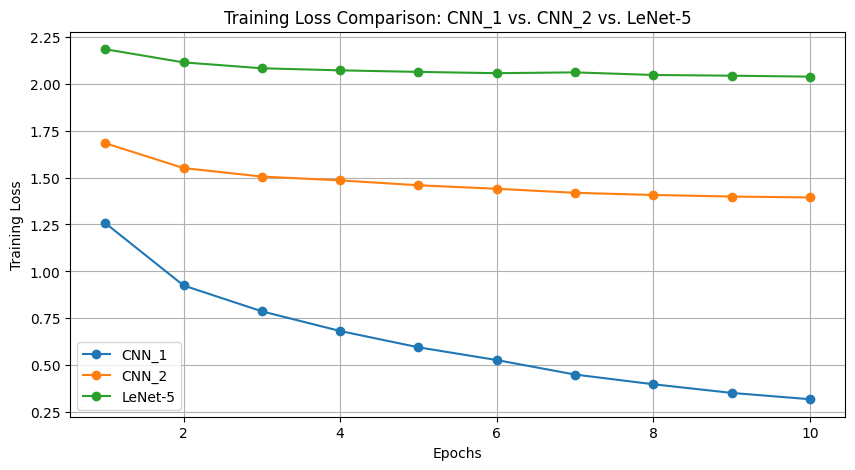

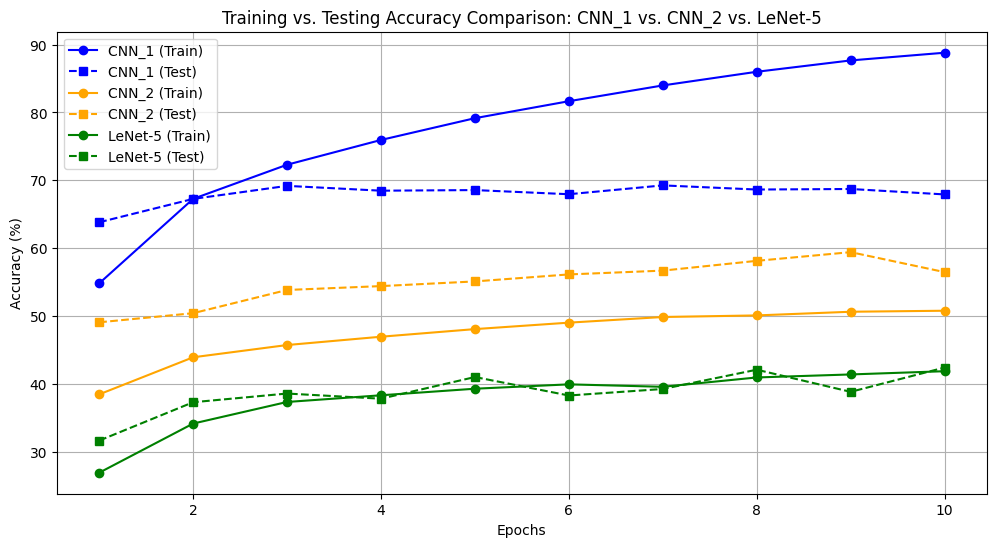

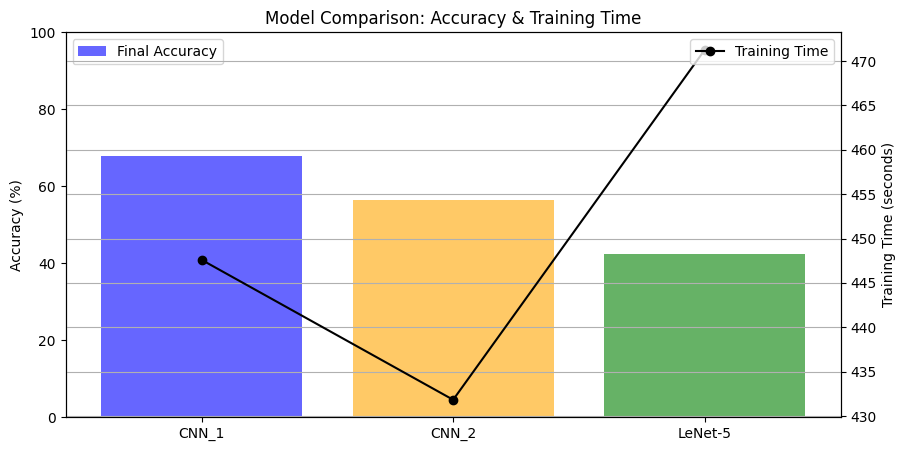

In [24]:
# Extracting results for plotting
train_losses = {name: traditional_results[name]["train_losses"] for name in traditional_models}
train_accuracies = {name: traditional_results[name]["train_accuracies"] for name in traditional_models}
test_accuracies = {name: traditional_results[name]["test_accuracies"] for name in traditional_models}
final_accuracies = {name: traditional_results[name]["final_test_accuracy"] for name in traditional_models}
training_times = {name: traditional_results[name]["total_training_time"] for name in traditional_models}

# Plot Training Loss Progression
plt.figure(figsize=(10, 5))
for model_name, losses in train_losses.items():
    plt.plot(range(1, len(losses) + 1), losses, label=model_name, marker="o", linestyle="-")

plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss Comparison: CNN_1 vs. CNN_2 vs. LeNet-5")
plt.legend()
plt.grid(True)
plt.show()

# Define colors for each model
colors = {"CNN_1": "blue", "CNN_2": "orange", "LeNet-5": "green"}

plt.figure(figsize=(12, 6))

for model_name in traditional_models:
    plt.plot(range(1, len(train_accuracies[model_name]) + 1), train_accuracies[model_name],
             label=f"{model_name} (Train)", marker="o", linestyle="-", color=colors[model_name])
    plt.plot(range(1, len(test_accuracies[model_name]) + 1), test_accuracies[model_name],
             label=f"{model_name} (Test)", marker="s", linestyle="--", color=colors[model_name])

plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs. Testing Accuracy Comparison: CNN_1 vs. CNN_2 vs. LeNet-5")
plt.legend()
plt.grid(True)
plt.show()


# Plot Training Time and Accuracy Comparison
fig, ax1 = plt.subplots(figsize=(10, 5))

# Bar chart for accuracy
ax1.bar(final_accuracies.keys(), final_accuracies.values(), color=['blue', 'orange', 'green'], alpha=0.6, label="Final Accuracy")
ax1.set_ylabel("Accuracy (%)")
ax1.set_ylim(0, 100)

# Line plot for training time
ax2 = ax1.twinx()
ax2.plot(training_times.keys(), training_times.values(), marker="o", color="black", label="Training Time")
ax2.set_ylabel("Training Time (seconds)")

# Labels and title
plt.title("Model Comparison: Accuracy & Training Time")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.grid(True)
plt.show()

#save the models after they have been trained
torch.save(traditional_models["CNN_1"], 'CNN_1.pth')
torch.save(traditional_models["CNN_2"], 'CNN_2.pth')
torch.save(traditional_models["LeNet-5"], 'LeNet-5.pth')

#### Traditional Training takaways

1. **Training Loss Comparison**

*The first graph shows the training loss curves fro the three CNN architectuires over 10 epochs.*

- CNN_1 shows the most significant decrease in loss, showing how effective it is in learning. 
- CNN_2 has a slower loss reduction, showing it has a less effective architecture than CNN_1.
- Lenet_5 perfoms the worst with its loss remaining relitively high, indicating underfitting and it struggles to capture the patterns in the dataset.

CNN_1 outperforms the other models in minimizing loss, suggesting it is better at learning compared to the other models.

<br>

2. **Training vs. Testing Accuracy**

*The second Graph Compares training and testing accuracy over 10 epochs for all models*

- CNN_1 achieved the highest accuracy, but there is a noticable gap between the training accuracy and the testing accuracy which suggests that the model is potentilly overfiting to the training data set.
- CNN_2 has a good accuracy, and much less over fitting compare to CNN_1.
- Lenet_5 has the worst accuracy, and shows limitied generalization ability.

CNN_1 learns the best but risks overfitting, while CNN_2 has the best generalization but has a lower accuracy, and Lenet_5 shows underfitting behaviour, and may not be deep enough for this task.

<br>

3. **Model Comparison: Accuracy and Training Time**

*The third graph shows the final accuracy and traing time of each of the models.*

- CNN_1 achieved the best accuracy(~70%) but had reletively higher training time compared to CNN_2.
- CNN_2 was the trained the fastest(~430 seconds) and had a reasonable accuracy(~55%)-time tradeoff.
- Lenet_5 Had the worst accuracy(~40%) and took the longest amount of time to train(~470 seconds).

CNN_1 overall is the best performing model but has the risk of overtraining, CNN_2 is the most efficient model with a resonable accuracy-time trade. But Lenet_5 is the worst model both in training time and in accuracy making it the most inefficent model.

### **Genetic algorithm Comparison**

Unlike backpropagation, genetic algorithms (GA) optimize neural networks through evolutionary **selection**, **mutation**, and **crossover**. Here, we compare GA-trained models against traditionally trained ones to assess their effectiveness in accuracy, efficiency, and generalization.

In [25]:
# Define models
models = {
    "CNN_1": CNN,
    "CNN_2": CNN_2,
    "LeNet-5": LeNet5,
}

# Store results
ga_results = {}

for model_name, model_class in models.items():
    print(f"\nRunning Genetic Algorithm for {model_name}...")

    # Run GA for this model
    ga_results[model_name] = run_genetic_algorithm(model_class, CRITERION, POPULATION_SIZE, GENERATIONS, trainloader, testloader, epochs=EPOCHS, mutation_rate=MUTATION_RATE)


Running Genetic Algorithm for CNN_1...

Generation 1
Epoch 1/2 | Loss: 1.4241 | Train_Accuracy: 48.52% | Test_Accuracy: 62.49% | Time: 41.24s
Epoch 2/2 | Loss: 0.9822 | Train_Accuracy: 65.41% | Test_Accuracy: 64.52% | Time: 40.82s
Epoch 1/2 | Loss: 1.4336 | Train_Accuracy: 48.30% | Test_Accuracy: 58.25% | Time: 40.79s
Epoch 2/2 | Loss: 0.9969 | Train_Accuracy: 64.64% | Test_Accuracy: 65.32% | Time: 40.37s
Epoch 1/2 | Loss: 1.4140 | Train_Accuracy: 48.94% | Test_Accuracy: 61.95% | Time: 40.77s
Epoch 2/2 | Loss: 0.9836 | Train_Accuracy: 65.09% | Test_Accuracy: 67.21% | Time: 41.07s
Epoch 1/2 | Loss: 1.4174 | Train_Accuracy: 48.85% | Test_Accuracy: 58.39% | Time: 40.59s
Epoch 2/2 | Loss: 0.9854 | Train_Accuracy: 65.01% | Test_Accuracy: 68.21% | Time: 40.80s
Epoch 1/2 | Loss: 1.4134 | Train_Accuracy: 48.90% | Test_Accuracy: 60.01% | Time: 40.30s
Epoch 2/2 | Loss: 0.9737 | Train_Accuracy: 65.52% | Test_Accuracy: 66.20% | Time: 40.56s
Epoch 1/2 | Loss: 1.4220 | Train_Accuracy: 48.53% | Test


CNN_1 Final Best Accuracy: 72.34%
CNN_1 Time Taken Per Generation: [716.5145711898804, 361.67985582351685, 361.3460285663605, 358.32031512260437, 361.83901834487915]

CNN_2 Final Best Accuracy: 60.48%
CNN_2 Time Taken Per Generation: [729.3717422485352, 361.5985035896301, 359.5947709083557, 359.2446074485779, 359.83068108558655]

LeNet-5 Final Best Accuracy: 55.32%
LeNet-5 Time Taken Per Generation: [781.8795115947723, 388.60973596572876, 389.52854895591736, 390.57466864585876, 392.8741281032562]

      Model  Final Accuracy (%)  Total Training Time (s)
0    CNN_1               72.34              2159.699789
1    CNN_2               60.48              2169.640305
2  LeNet-5               55.32              2343.466593


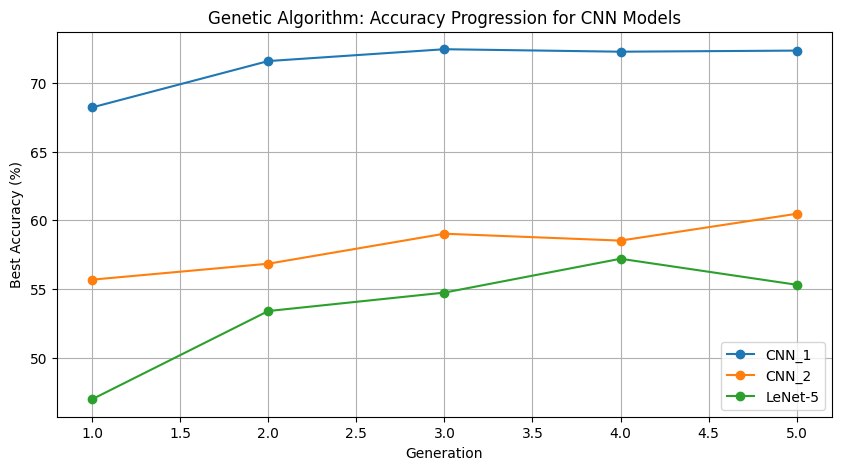

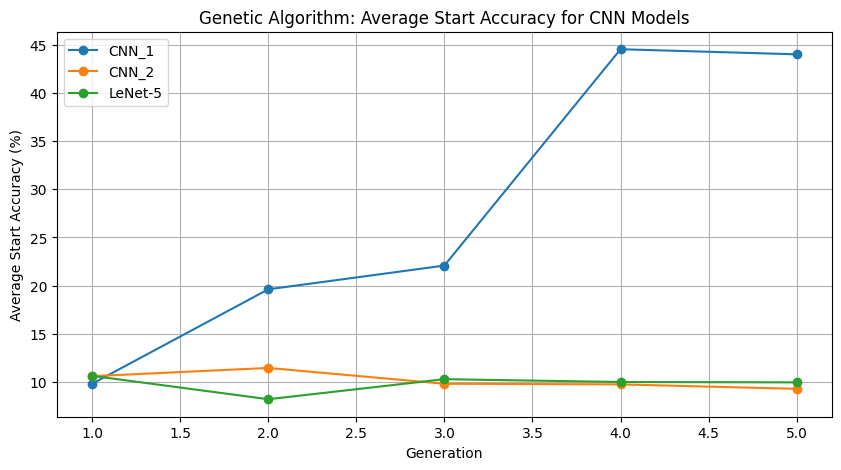

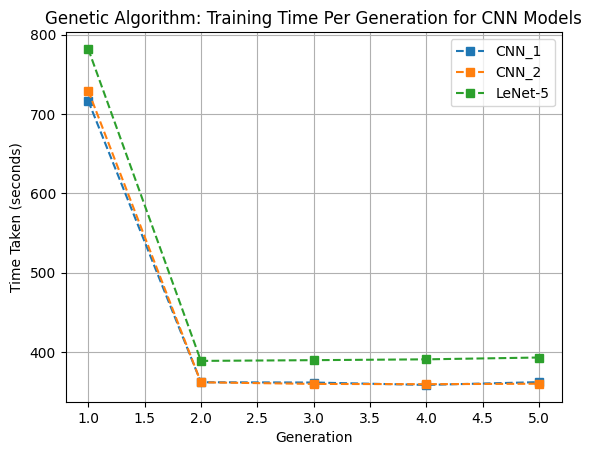

In [29]:
# Print Summary for Each Model
for model_name, results in ga_results.items():
    print(f"\n{model_name} Final Best Accuracy: {results['best_accuracies'][-1]:.2f}%")
    print(f"{model_name} Time Taken Per Generation: {results['generation_times']}")

# Create a DataFrame to compare the genetic algorithm results
ga_comparison_data = []  # Use a list to store rows before creating the DataFrame

for model_name, results in ga_results.items():
    final_accuracy = results["best_accuracies"][-1]
    total_training_time = sum(results["generation_times"])
    ga_comparison_data.append({"Model": model_name, "Final Accuracy (%)": final_accuracy, "Total Training Time (s)": total_training_time})

# Convert the list into a DataFrame
ga_comparison_df = pd.DataFrame(ga_comparison_data)

# Print the DataFrame
print("\n",ga_comparison_df)

# Extract results for visualization
# Extract best accuracies and generation times for each model
best_accuracies = {name: results["best_accuracies"] for name, results in ga_results.items()}
generation_times = {name: results["generation_times"] for name, results in ga_results.items()}
average_start_accuracies = {name: results["average_start_accuracies"] for name, results in ga_results.items()}


plt.figure(figsize=(10, 5))

# Plot accuracy curves for all models
for model_name, accuracies in best_accuracies.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker="o", linestyle="-", label=model_name)

plt.xlabel("Generation")
plt.ylabel("Best Accuracy (%)")
plt.title("Genetic Algorithm: Accuracy Progression for CNN Models")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))

# Plot average start accuracies for all models
for model_name, accuracies in average_start_accuracies.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker="o", linestyle="-", label=model_name)

plt.xlabel("Generation")
plt.ylabel("Average Start Accuracy (%)")
plt.title("Genetic Algorithm: Average Start Accuracy for CNN Models")
plt.legend()
plt.grid(True)
plt.show()

# Plot training time curves for all models
for model_name, times in generation_times.items():
    plt.plot(range(1, len(times) + 1), times, marker="s", linestyle="--", label=model_name)

plt.xlabel("Generation")
plt.ylabel("Time Taken (seconds)")
plt.title("Genetic Algorithm: Training Time Per Generation for CNN Models")
plt.legend()
plt.grid(True)
plt.show()

# save the best models
torch.save(ga_results["CNN_1"]["best_model"].state_dict(), "ga_cnn_1.pth")
torch.save(ga_results["CNN_2"]["best_model"].state_dict(), "ga_cnn_2.pth")
torch.save(ga_results["LeNet-5"]["best_model"].state_dict(), "ga_lenet5.pth")


#### **Genetic algorithm Findings**

1. **Accuracy Progression Over Generations**

*The first graph shows the accuracy improvement of CNN_1, CNN_2, and LeNet-5 across five generations trained using a genetic algorithm (GA).*

- CNN_1 achieved the highest accuracy and showed steady improvement over the generations.
- CNN_2 showed a slower (but still stable) learning rate than CNN_1.
- Lenet_5 has the worst accuracy, and showed barely any improvemnt befor plateauing.

GA successfully optimized CNN_1, leading to the highest accuracy. However, Lenet_5 did not improve much, probaly due to architectual limitations.

2. **Average Start Accuracy Per Generation**

*The second graph tracks the average start accuracy per generation*

- CNN_1 average start accuary shows constant improvement through the generations, which shows that the GA is effectivey refines the high performing solutions.
- CNN_2 and Lenet5 show minimal changes

CNN_1 benefits the most from the GA-based evolution, showing that it was best adapted for the mutation and crossover operations used, whilst the CNN_2 and the Letnet5 may require difernt strateges for better improvements.

3. **Training Time Per Generation**

*The third graph tracks the training time across generations.*

- Training time droped significantly after the first generation and stay consistent across susequent generations.

This graph was as expected beacuse the genetic algorithm reduced the population size by half after the first generation. so all models performed as expected in this area.

---
## **Ensemble Learning: Combining GA-Trained CNNs** <a id="Ensemble-Learning-Combining-GA-Trained-CNNs"></a>

**What is Ensembling?**

Ensembling is a machine learning technique where mulitple models are combined to produce a more robust and accurate prediction. so instead of just using one model, ensembling leverages the strengths of multiple models, reducing variance, improving generalization and mitigating the weaknesses of the individual networks. <br>

In this project we will implement two ensembling strategies:
1. **Simple Ensemble** (Average Outputs)
2. **Weighted Ensemble** (Accuracy based Weighting)

### 1. **Simple Ensemble (Averaging Outputs)**

**How it works:** <br>
This method simply collects predictions from multiple CNN models. Then averages their ouputs effectively smoothing the final decision. Reducing overfitting, as errors from individual models are averaged out.

**Potential Benefits:** <br>
improves generalization by leverging diverse predictions. Reduces model varience, leading to more stable outputs. Helps mitigate bias in individual modes by balancing their predictions.

In [26]:
# from source [6] modified to be more dynamic and to instead average the outputs of the models
# define a class to ensemble multiple models
class Ensemble(nn.Module):
    def __init__(self, models):
        super(Ensemble, self).__init__()
        self.models = models

    def forward(self, x):
        # Get predictions from each model
        outputs = [model(x) for model in self.models]
        # Average the predictions
        outputs = torch.stack(outputs, dim=0).mean(dim=0)
        return outputs
#end of source [6]

In [31]:
# # combine the GA models into an ensemble
ensemble_model = Ensemble([ga_results["CNN_1"]["best_model"], ga_results["CNN_2"]["best_model"], ga_results["LeNet-5"]["best_model"]])

# Test the ensemble model
ensemble_accuracy = test_nn(ensemble_model, testloader)
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.2f}%")

Ensemble Model Accuracy: 73.40%


In [40]:
# Determine the device dynamically
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models onto the appropriate device
cnn_1 = torch.load('CNN_1.pth', map_location=device)
cnn_2 = torch.load('CNN_2.pth', map_location=device)
lenet5 = torch.load('LeNet-5.pth', map_location=device)

# test the ensambled traditional models
ensemble_model_traditional = Ensemble([cnn_1, cnn_2, lenet5])
ensemble_accuracy_traditional = test_nn(ensemble_model_traditional, testloader)

print(f"Ensemble Model Accuracy: {ensemble_accuracy_traditional:.2f}%")

C:\Users\Emman\AppData\Local\Temp\ipykernel_29152\1295196162.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_1 = torch.load('CNN_1.pth', map_location=device)
C:\User

Ensemble Model Accuracy: 70.37%


In [ ]:
# Train the individual models within the ensemble
for model in ensemble_model_traditional.models:
	criterion = nn.CrossEntropyLoss()
	optimizer = optim.Adam(model.parameters(), lr=0.001)
	train_nn(model, trainloader, criterion, optimizer, epochs=3)

Epoch 1/3 | Loss: 0.3002 | Train_Accuracy: 89.61% | Test_Accuracy: 68.40 | Time: 103.90s
Epoch 2/3 | Loss: 0.2717 | Train_Accuracy: 90.85% | Test_Accuracy: 68.06 | Time: 117.88s
Epoch 3/3 | Loss: 0.2484 | Train_Accuracy: 91.73% | Test_Accuracy: 66.91 | Time: 108.00s
Epoch 1/3 | Loss: 1.3943 | Train_Accuracy: 50.98% | Test_Accuracy: 57.97 | Time: 73.91s
Epoch 2/3 | Loss: 1.3922 | Train_Accuracy: 51.05% | Test_Accuracy: 58.12 | Time: 68.75s
Epoch 3/3 | Loss: 1.3872 | Train_Accuracy: 51.06% | Test_Accuracy: 57.96 | Time: 74.62s
Epoch 1/3 | Loss: 2.0375 | Train_Accuracy: 41.89% | Test_Accuracy: 42.74 | Time: 109.53s
Epoch 2/3 | Loss: 2.0368 | Train_Accuracy: 41.98% | Test_Accuracy: 39.38 | Time: 143.07s


### 2. **Weighted Ensemble (Accuracy-Based Combination)**

**How it works:** <br>
This method assigns different weights to models based on their accuracy. More accurate models contribute more influence to the final prediction. Instead of simply averaging, this method prioritzes better performing medels.

**Potential Benefits:** <br>
Enhances predictive performance by favouring high-accuracy models. Allows for adaptive learning, where strong models dominate the weak ones. More effective than simple averaging when the model performance vary significantly.

In [31]:
class WeightedEnsemble(nn.Module):
    def __init__(self, models, accuracies):
        """
        Initializes a weighted ensemble of models.

        Args:
            models (list): List of PyTorch models.
            accuracies (list): Corresponding accuracy scores of the models.
        """
        super(WeightedEnsemble, self).__init__()
        self.models = models

        # Normalize accuracies to sum to 1 (to create valid weights)
        total_accuracy = sum(accuracies)
        self.weights = [acc / total_accuracy for acc in accuracies]

    def forward(self, x):
        # Get predictions from each model and weight them
        weighted_outputs = [
            model(x) * weight for model, weight in zip(self.models, self.weights)
        ]

        # Sum the weighted outputs
        outputs = torch.stack(weighted_outputs, dim=0).sum(dim=0)
        return outputs

In [33]:
# Define models and their accuracies
models = [ga_results["CNN_1"]["best_model"], ga_results["CNN_2"]["best_model"], ga_results["LeNet-5"]["best_model"]]
accuracies = [
    ga_results["CNN_1"]["best_accuracies"][-1],
    ga_results["CNN_2"]["best_accuracies"][-1],
    ga_results["LeNet-5"]["best_accuracies"][-1]
]

# Create a weighted ensemble model
weighted_ensemble_model = WeightedEnsemble(models, accuracies)

# Evaluate the weighted ensemble model
ensemble_accuracy = test_nn(weighted_ensemble_model, testloader)
print(f"Weighted Ensemble Model Accuracy: {ensemble_accuracy:.2f}%")

Weighted Ensemble Model Accuracy: 73.53%


In [ ]:
# #test the weighted esemble model with the traditional models
# models = [cnn_1, cnn_2, lenet5]
# accuracies = [test_nn(cnn_1,testloader), test_nn(cnn_2,testloader), test_nn(lenet5,testloader)]

# weighted_ensemble_model_traditional = WeightedEnsemble(models, accuracies)
# ensemble_accuracy_traditional = test_nn(weighted_ensemble_model_traditional, testloader)



Weighted Ensemble Model Accuracy: 70.12%


---

## **Evaluation and Visualization** <a id="Evaluation-and-Visualization"></a>

**Evaluation Function**

In [34]:
def evaluate_model(model, testloader, classes, use_gpu=True):
    """
    Evaluates a CNN model by computing overall accuracy, per-class accuracy, and confusion matrix.

    Args:
        model: PyTorch model to evaluate.
        testloader: DataLoader for testing data.
        classes: List of class labels.
        use_gpu (bool, optional): Enables GPU acceleration. Default is True.

    Returns:
        results (dict): Dictionary containing:
            - 'class_accuracies': Dictionary of per-class accuracy.
            - 'accuracy': Overall test accuracy.
            - 'confusion_matrix': Confusion matrix (numpy array).
    """
    # Move model to GPU if available
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model.to(device)

    # Evaluate the model
    accuracy = test_nn(model, testloader, use_gpu=use_gpu)

    # Compute per-class accuracy
    test_class_accuracies = test_nn_per_class(model, testloader, classes, use_gpu=use_gpu)

    #This was made with ChatGPT code to generate a confusion matrix look at source [7] for more details
    # Compute Confusion Matrix
    all_preds = []
    all_labels = []
    model.eval()

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    conf_matrix = confusion_matrix(all_labels, all_preds)
    ### End of source [7]

    # Return evaluation results
    results = {
        "class_accuracies": test_class_accuracies,
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix,
    }

    return results


**Visulisation Function**

In [35]:
def visualize_evaluation_results(results, classes):
    """
    Visualizes loss, accuracy trends, and confusion matrix from model evaluation results.

    Args:
        results (dict): Dictionary containing evaluation results.
        classes (list): List of class labels.
    """
    # Plot Per-Class Accuracy
    plt.figure(figsize=(10, 5))
    plt.bar(results["class_accuracies"].keys(), results["class_accuracies"].values(), color='blue')
    plt.xlabel("Classes")
    plt.ylabel("Accuracy (%)")
    plt.title("Model Accuracy Per Class")
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.show()

    # Generate Confusion Matrix
    print("\nGenerating confusion matrix...")

    plt.figure(figsize=(8, 6))
    sns.heatmap(results["confusion_matrix"], annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()


In [39]:
# create a dictionary to store model name, model accuracy and model training time
evaluation_results = {}

# list of models to evaluate
traditional_models_to_evaluate = {
    "CNN_1": traditional_models["CNN_1"],
    "CNN_2": traditional_models["CNN_2"],
    "LeNet-5": traditional_models["LeNet-5"]
}

ga_trained_models_to_evaluate = {
    "CNN_1": ga_results["CNN_1"]["best_model"],
    "CNN_2": ga_results["CNN_2"]["best_model"],
    "LeNet-5": ga_results["LeNet-5"]["best_model"]
}

ensemble_models_to_evaluate = {
    "Ensemble": ensemble_model,
    "Weighted Ensemble": weighted_ensemble_model
}


Evaluating CNN_1...

Finished per-class testing.


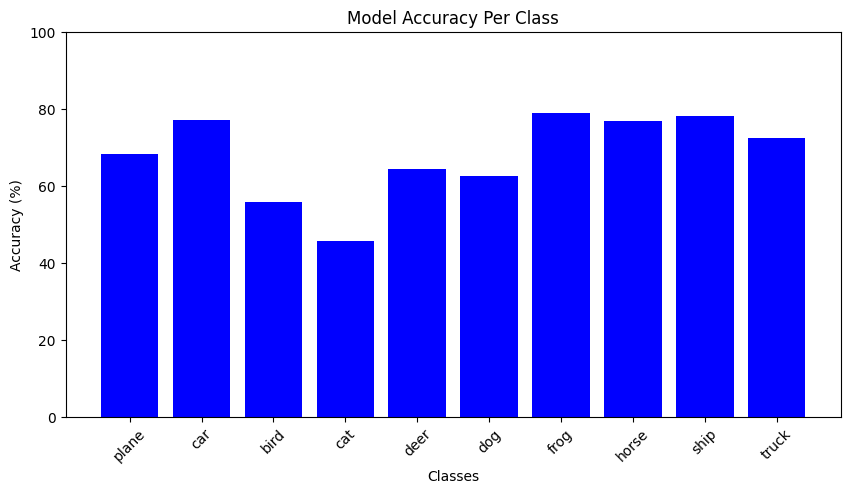


Generating confusion matrix...


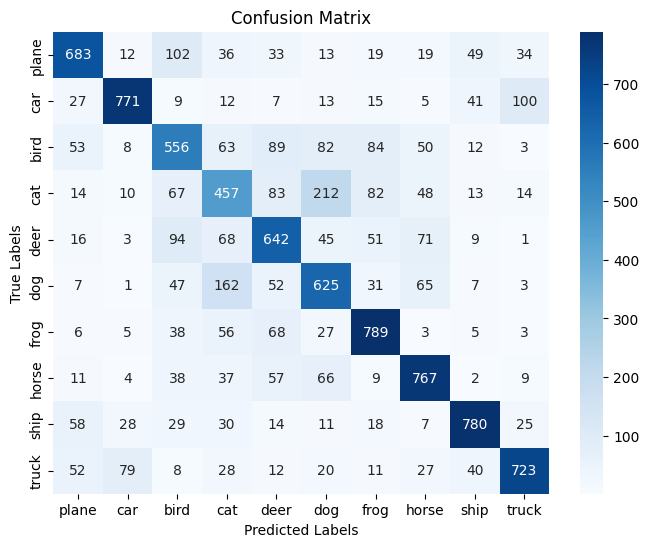


Evaluating CNN_2...

Finished per-class testing.


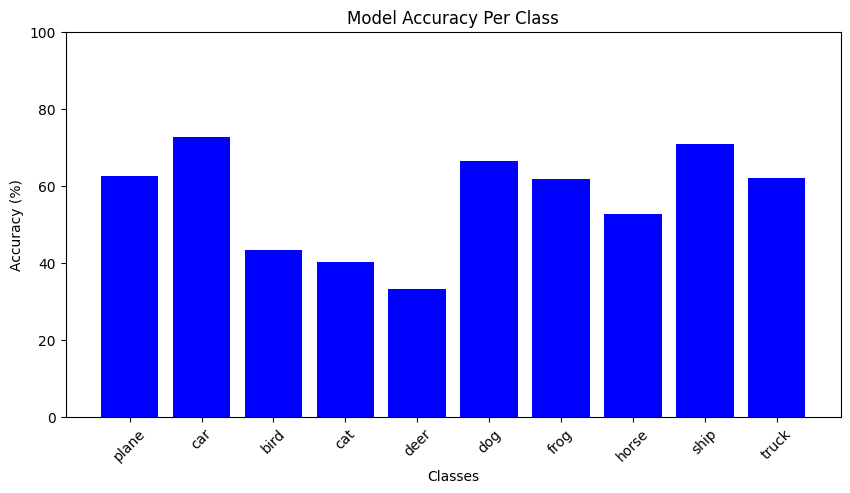


Generating confusion matrix...


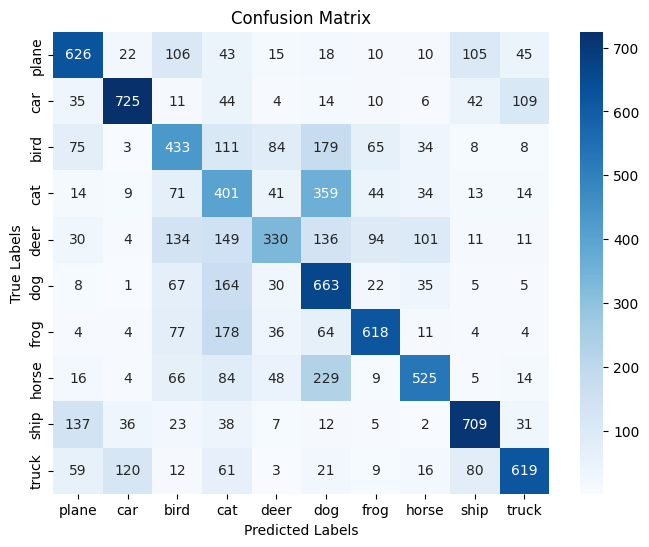


Evaluating LeNet-5...

Finished per-class testing.


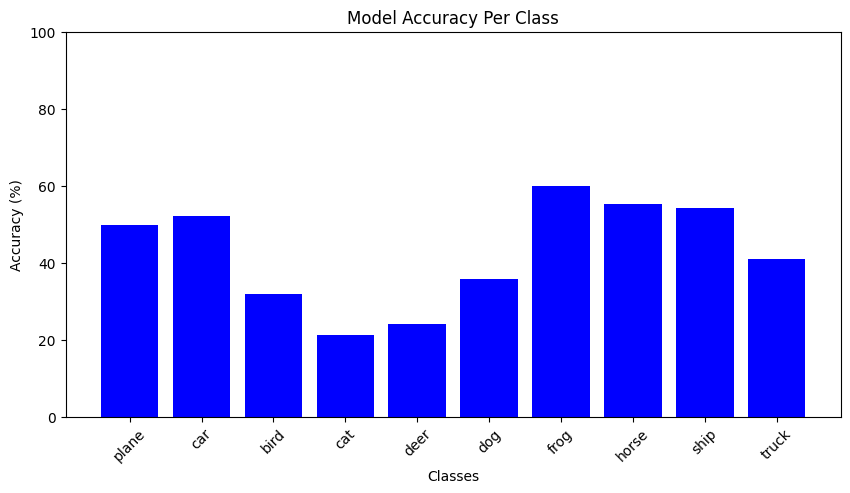


Generating confusion matrix...


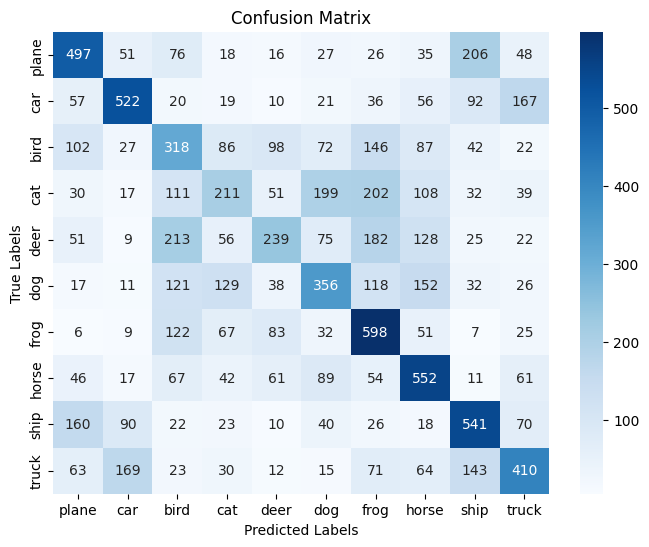

In [40]:
# evaluate and visulise all the traditionally trained models
for model_name, model in traditional_models_to_evaluate.items():
    print(f"\nEvaluating {model_name}...\n")
    results = evaluate_model(model, testloader, classes, use_gpu=USE_GPU)
    visualize_evaluation_results(results, classes)

    # Store results
    evaluation_results[model_name] = {
        "accuracy": results["accuracy"],
        "training_time": traditional_results[model_name]["total_training_time"]
    }

### **Traditional method Evaluation**


Evaluating GA CNN_1...

Finished per-class testing.


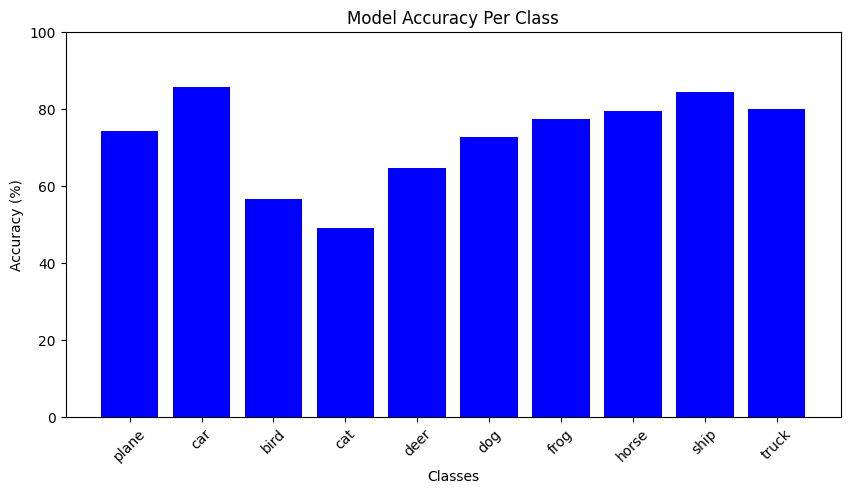


Generating confusion matrix...


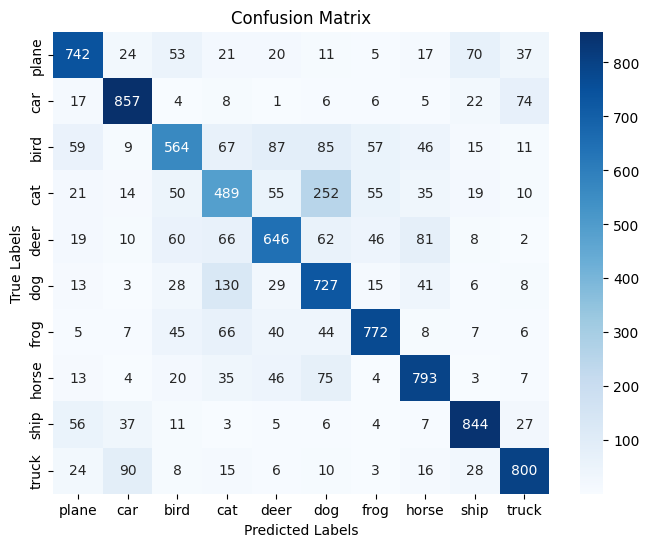


Evaluating GA CNN_2...

Finished per-class testing.


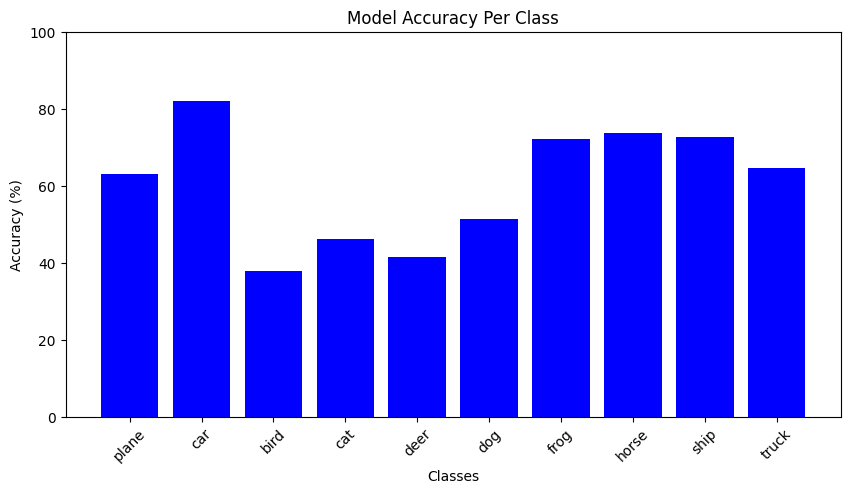


Generating confusion matrix...


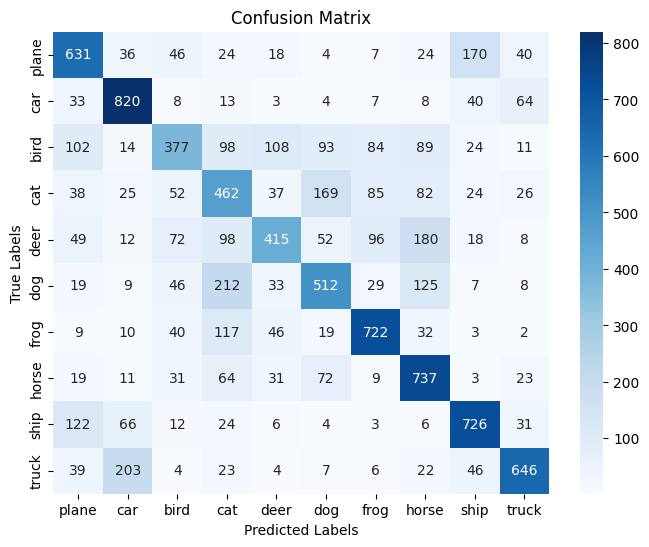


Evaluating GA LeNet-5...

Finished per-class testing.


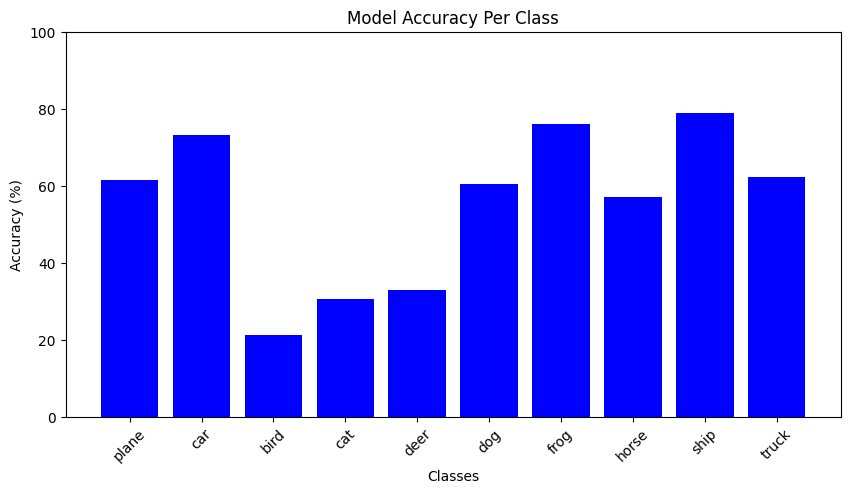


Generating confusion matrix...


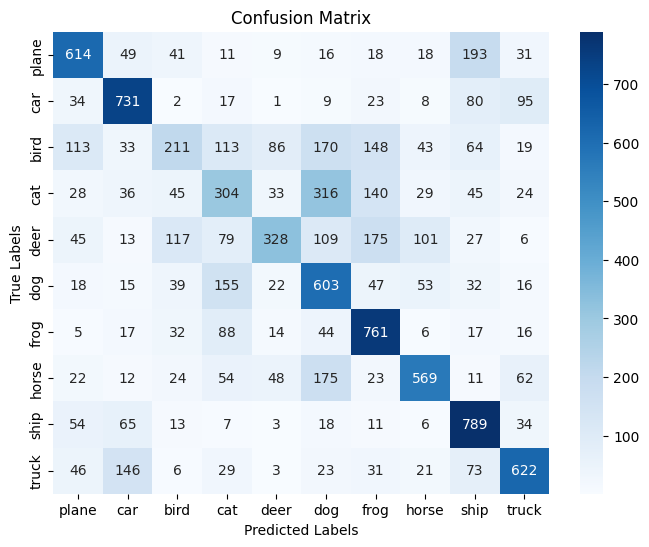

In [41]:
# Evaluate and visualize best models from GA optimised models
for model_name, model in ga_trained_models_to_evaluate.items():
    print(f"\nEvaluating GA {model_name}...\n")
    results = evaluate_model(model, testloader, classes, use_gpu=USE_GPU)

    visualize_evaluation_results(results, classes)

    model_name2 = "GA " + model_name

    # Store results
    evaluation_results[model_name2] = {
        "accuracy": results["accuracy"],
        "training_time": sum(ga_results[model_name]["generation_times"])
    }



Evaluating Ensemble...

Finished per-class testing.


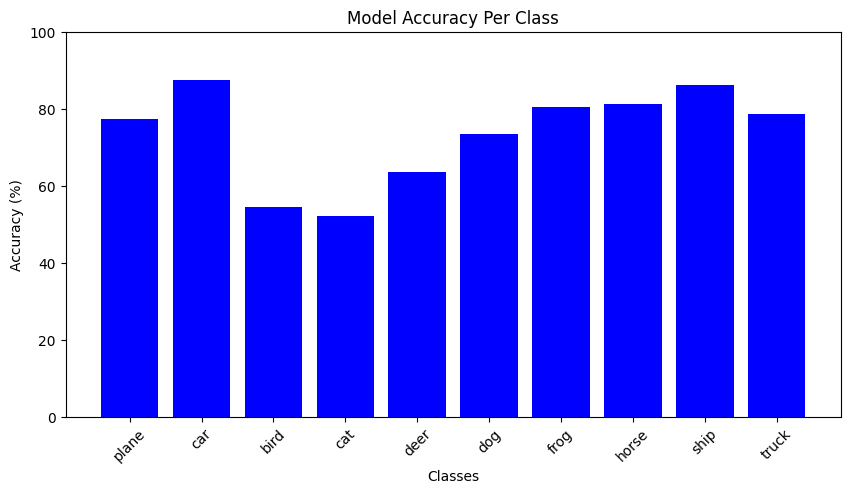


Generating confusion matrix...


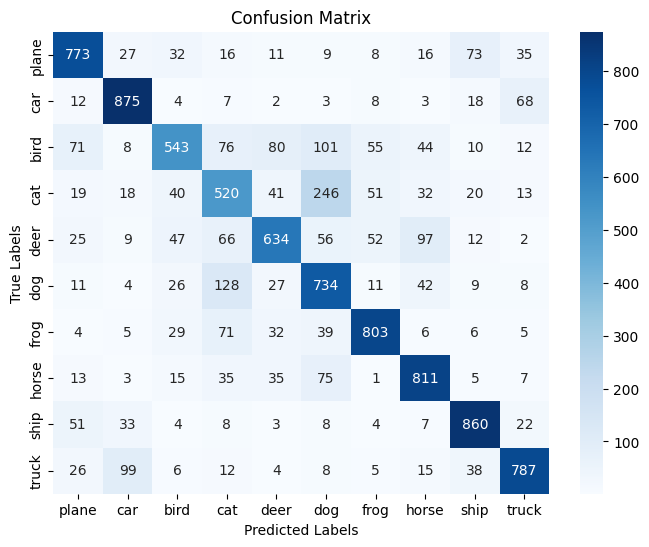


Evaluating Weighted Ensemble...

Finished per-class testing.


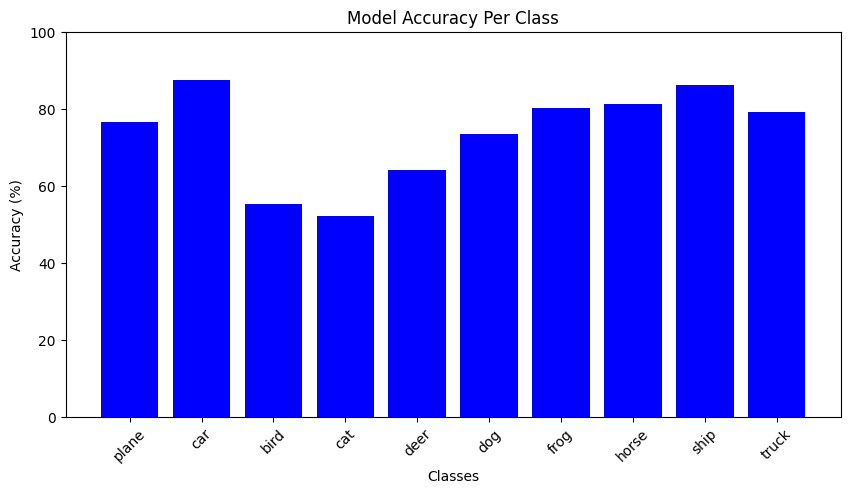


Generating confusion matrix...


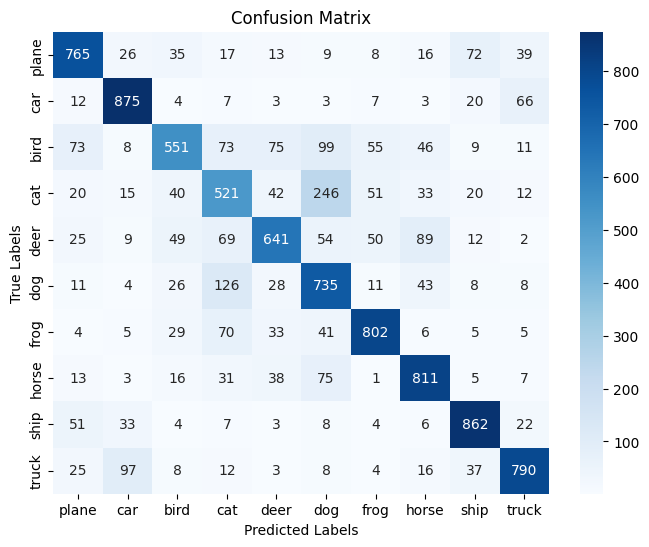

In [42]:
# Evaluate and visualize ensemble models
for model_name, model in ensemble_models_to_evaluate.items():
    print(f"\nEvaluating {model_name}...\n")
    results = evaluate_model(model, testloader, classes, use_gpu=USE_GPU)

    visualize_evaluation_results(results, classes)

    # Store results
    evaluation_results[model_name] = {
        "accuracy": results["accuracy"],
        "training_time": 0
    }

In [43]:
#create a function to compare the accuracy of models and print a table of the results
def compare_models_table(results):
    """
    Compares the accuracy of different models and prints a table of the results.

    Args:
        results (dict): Dictionary containing evaluation results for each model.
    """
    # Create a DataFrame to compare the results
    data = {
        "Model": [],
        "Final Accuracy (%)": [],
        "Training Time (s)": []
    }

    for model_name, model_results in results.items():
        accuracy = model_results["accuracy"]
        training_time = model_results["training_time"]
        data["Model"].append(model_name)
        data["Final Accuracy (%)"].append(f"{accuracy:.2f}")
        data["Training Time (s)"].append(f"{training_time:.2f}")

    df = pd.DataFrame(data)
    print(df)

In [44]:
print("Model Evalutaion Results:\n")
compare_models_table(evaluation_results)

Model Evalutaion Results:

               Model Final Accuracy (%) Training Time (s)
0              CNN_1              67.93            447.60
1              CNN_2              56.49            431.83
2            LeNet-5              42.44            471.27
3           GA CNN_1              72.34           2159.70
4           GA CNN_2              60.48           2169.64
5         GA LeNet-5              55.32           2343.47
6           Ensemble              73.40              0.00
7  Weighted Ensemble              73.53              0.00


---
## **Conclusion** <a id="Conclusion"></a>

Our best performing CNN was the weighted ensemble model having an acuracy of 73.53% a whole 0.13% higher than the runner up, average ensemble model. howerver further improvements can be made: 

-
-
-




---
## **Tutorial comparison** <a id="tutorial-comparison"></a>


---
## **References** <a id="References"></a>
*Citations and references for further reading.*

[1] PyTorch, "CIFAR-10 tutorial," PyTorch Tutorials. Available: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html. <br>

[2] GeeksforGeeks, "How to implement genetic algorithm using PyTorch," GeeksforGeeks. Available: https://www.geeksforgeeks.org/how-to-implement-genetic-algorithm-using-pytorch/. <br>


[3] S. Raschka, "CNN LeNet-5 CIFAR-10 implementation," GitHub Repository. Available: https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-lenet5-cifar10.ipynb. <br>


[4] Androbomb, "Using CNN to classify images with PyTorch," Kaggle. Available: https://www.kaggle.com/code/androbomb/using-cnn-to-classify-images-w-pytorch. <br>


[5] A. Popov, "How to train an ensemble of convolutional neural networks for image classification," Medium. Available: https://medium.com/@alexppppp/how-to-train-an-ensemble-of-convolutional-neural-networks-for-image-classification-8fc69b087d3. <br>
